In [69]:
%matplotlib inline

In [70]:
import scipy.optimize
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata

In [71]:
def normalize_features(train, test):
    """Normalizes train set features to a standard normal distribution
    (zero mean and unit variance). The same procedure is then applied
    to the test set features.
    """
    train_mean = train.mean(axis=0)
    # +0.1 to avoid division by zero in this specific case
    train_std = train.std(axis=0) + 0.1
    
    train = (train - train_mean) / train_std
    test = (test - train_mean) / train_std
    return train, test

First get and preprocess the data.

In [72]:
# get data: contains 70k samples of which the last 10k are meant for testing
mnist = fetch_mldata('MNIST original', data_home='./data')

# prepare for concat
y_all = mnist.target[:, np.newaxis]

# intercept term to be added
intercept = np.ones_like(y_all)

# normalize the data (zero mean and unit variance)
train_normalized, test_normalized = normalize_features(
    mnist.data[:60000, :],
    mnist.data[60000:, :],
)

# concat intercept, X, and y so that shuffling is easier in a next step
train_all = np.hstack((
    intercept[:60000],
    train_normalized,
    y_all[:60000],
))
test_all = np.hstack((
    intercept[60000:],
    test_normalized,
    y_all[60000:],
))

In [73]:
print mnist.data.shape

(70000, 784)


I don't think this randomization step is really needed in our case, but let's stick with the ufldl tutorial here.

In [74]:
np.random.shuffle(train_all)
np.random.shuffle(test_all)

Now prepare the final train and test datasets. Let's only pick the data for the digits `0` and `1`.

In [75]:
# train data
train_X = train_all[np.logical_or(train_all[:, -1] == 0, train_all[:, -1] == 1), :-1]
train_y = train_all[np.logical_or(train_all[:, -1] == 0, train_all[:, -1] == 1), -1]

# test data
test_X = test_all[np.logical_or(test_all[:, -1] == 0, test_all[:, -1] == 1), :-1]    
test_y = test_all[np.logical_or(test_all[:, -1] == 0, test_all[:, -1] == 1), -1]

# print train_all[:5]
# print test_all[:5]

In [76]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [77]:
def cost_function(theta, X, y):
    h = sigmoid(X.dot(theta))
    return -1 * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

In [78]:
def gradient(theta, X, y):
    errors = sigmoid(X.dot(theta)) - y
    return errors.dot(X)

In [79]:
J_history = []

t0 = time.time()
res = scipy.optimize.minimize(
    fun=cost_function,
    x0=np.random.rand(train_X.shape[1]) * 0.001,
    args=(train_X, train_y),
    method='L-BFGS-B',
    jac=gradient,
    options={'maxiter': 100, 'disp': True},
    callback=lambda x: J_history.append(cost_function(x, train_X, train_y)),
)
t1 = time.time()

print('Optimization took {s} seconds'.format(s=t1 - t0))
optimal_theta = res.x

Optimization took 1.06774401665 seconds


/Users/saurav.pandit/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/saurav.pandit/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/saurav.pandit/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from IPython.kernel.zmq import kernelapp as app


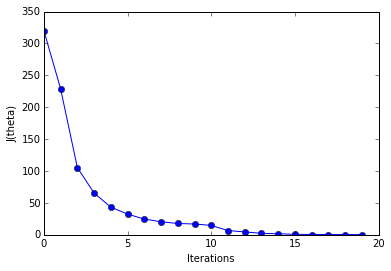

In [80]:
plt.plot(J_history, marker='o')
plt.xlabel('Iterations')
plt.ylabel('J(theta)')

In [81]:
def accuracy(theta, X, y):
    correct = np.sum(np.equal(y, np.round(sigmoid(X.dot(theta)))))
    print correct, y.size
    return float(correct) / y.size

In [82]:
print('Training accuracy: {acc}'.format(acc=accuracy(optimal_theta, train_X, train_y)))
print('Test accuracy: {acc}'.format(acc=accuracy(optimal_theta, test_X, test_y)))
# print test_y[:5]
# pred_y = np.round(sigmoid(test_X.dot(optimal_theta)))
# print pred_y[:5]
# print test_y.size
# print np.count_nonzero(~np.isnan(test_y))

12665 12665
Training accuracy: 1.0
2114 2115
Test accuracy: 0.999527186761


### Looking good, right? Well, look closer...
I actually had to use the **`L-BFGS-B`** optimization method for it to work.<br>
Had I used the expected **`BFGS`** method, **nan** and **inf** values due to `log(0)` would have made trouble.<br>
Why? I can think of two reasons:
1. Even if being multiplied with `0`, the `log(0)` expression is still evaluated by numpy. And unfortunately: `0 * np.nan = np.nan`.
2. Floating point arithmetic limits which don't exist in Mathematics.

One way to counteract those issues is to substitute the troubling values:

In [83]:
def safe_log(x, nan_substitute=-1e+4):
    l = np.log(x)
    l[np.logical_or(np.isnan(l), np.isinf(l))] = nan_substitute
    return l

In [84]:
def cost_function_safe(theta, X, y):
    h = sigmoid(X.dot(theta))
    return -1 * (y * safe_log(h) + (1 - y) * safe_log(1 - h)).sum()

In [85]:
J_history = []

t0 = time.time()
res = scipy.optimize.minimize(
    fun=cost_function_safe,
    x0=np.random.rand(train_X.shape[1]) * 0.001,
    args=(train_X, train_y),
    method='L-BFGS-B',
    jac=gradient,
    options={'maxiter': 100, 'disp': True},
    callback=lambda x: J_history.append(cost_function_safe(x, train_X, train_y)),
)
t1 = time.time()

print('Optimization took {s} seconds'.format(s=t1 - t0))
optimal_theta = res.x

Optimization took 0.345267057419 seconds


/Users/saurav.pandit/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


<br>
Notice that the above optimization procedure doesn't converge due to the substitutions (which doesn't allow the gradients to further improve (= get smaller) at some point). Therefore, it used all 100 allowed iterations.

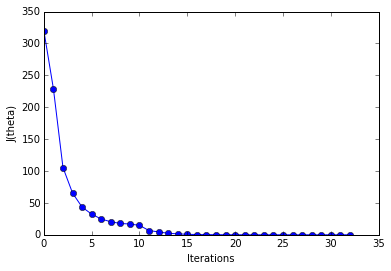

In [86]:
plt.plot(J_history, marker='o')
plt.xlabel('Iterations')
plt.ylabel('J(theta)')

In [87]:
print('Training accuracy: {acc}'.format(acc=accuracy(res.x, train_X, train_y)))
print('Test accuracy: {acc}'.format(acc=accuracy(res.x, test_X, test_y)))

12665 12665
Training accuracy: 1.0
2112 2115
Test accuracy: 0.998581560284
